[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/061_self_attention/self_attention.ipynb)

# Transformers - *Scaled Dot-Product Attention*

En el post anterior aprendimos qué es un mecanismo de atención, concepto fundamental en el desarrollo de los *Transformers*. Siguiendo con la lectura del artículo [*Attention is all you need*](https://arxiv.org/abs/1706.03762) vemos que los autores indican que el mecanismo de atención elegido para su nueva arquitectura es el *scaled dot-product attention*.

![](selfattention.png)

Este mecanismo de atención consiste en tres conjuntos de vectores $K$, $Q$ y $V$, llamados respectivamente *keys*, *queries* y *values*. Utilizaremos $K$ y $Q$ para calcular la matriz de atención, la cual aplicaremos a $V$. 

$$Attention(Q,K,V)= softmax(\frac{Q K^T}{\sqrt{d_k}}) V$$

Si te fijas, una formulación muy similar a la que ya usamos en el post anterior, con la diferencia de que en este caso escalamos el producto de $Q$ y $K$ con la raíz cuadrada de su dimensión, $d_k$ (detalles técnicos). ¿De dónde vienen estas $Q$, $K$ y $V$? Aquí es donde entra en juego la componente de aprendizaje. En los ejemplos que hemos visto anteriormente hemos trabajado con conjuntos de vectores definidos por nosotros mismos, y hemos calculado matrices de atención basándonos en sus valores. Sin embargo, para que este sistema sea capaz de aprender, calcularemos los diferentes vectores utilizando perceptrones: $Q = W_q X$, $K = W_k X$  y $V = W_v X$. De esta manera, nuestro sistema será capaz de calcular la mejor representación de $X$ para obtener un alineamiento óptimo en el mecanismo de atención.

> 💡 ¿Qué obtenemos si utilizamos un mecanismo de *hard-attention* en esta formulación? $$Attention(Q,K,V)= 1 V = W_v X$$ 🤯 Un mecanismo de atención, con *hard-attention*, no es más que un perceptrón de toda la vida. Esto significa que un perceptrón, hasta ahora visto como la unidad básica de cómputo en redes neuronales a partir de la cual se han desarrollado arquitecturas como redes recurrentes y convolucionales, es en realidad un caso particular de un mecanismo más general y potente. Esto abre un nuevo abanico de arquitectura, más allá del *transformer*, basado en mecanismos de atención. A grandes rasgos, puedes entender el mecanismo de atención como un perceptrón cuyos pesos dependen de los datos, en vez de ser siempre los mismos (resultado del entrenamiento).

## Ejemplo

Vamos a ver un ejemplo de implementación y caso de uso de este mecanismo de atención. Para ello, primero entrenaremos un MLP normal y corriente en la tarea de clasificación de imágenes con el dataset MNIST.

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [2]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [3]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

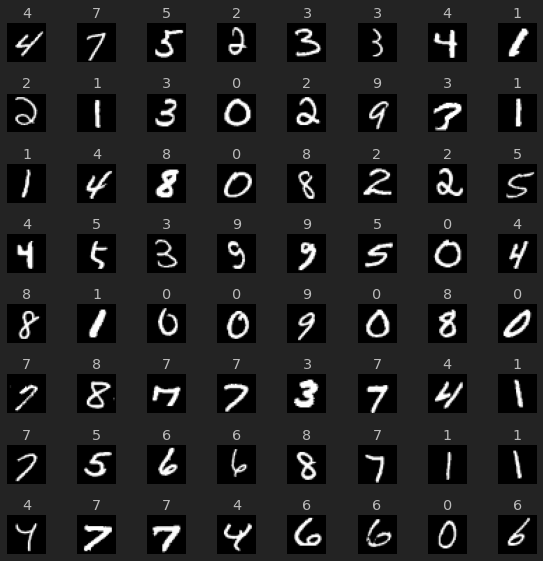

In [4]:
r, c = 8, 8
fig = plt.figure(figsize=(c, r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

In [5]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(784, 784),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(784, 10)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [6]:
mlp = MLP()
outuput = mlp(torch.randn(64, 784))
outuput.shape

torch.Size([64, 10])

In [7]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(mlp, dm)

/home/sensio/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to impro

Validation sanity check: 0it [00:00, ?it/s]

/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

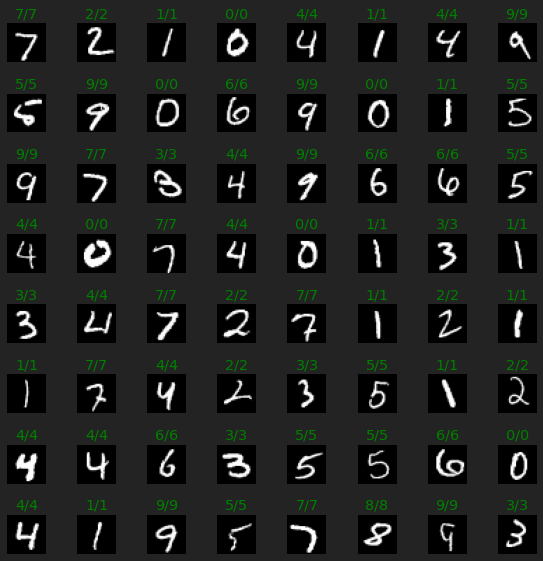

In [8]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c, r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Vamos ahora a resolver el mismo problema, utilizando un mecanismo de atención. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con secuencias, por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar.

In [9]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X 
    self.y = y 
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()

In [10]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 16, 49]), torch.Size([64]))

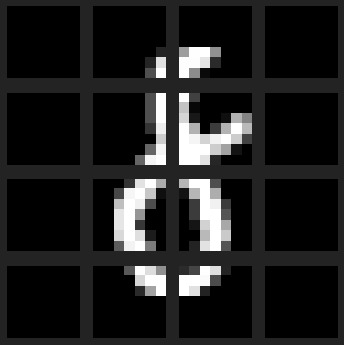

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[6,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        
        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values 
        k = self.key(x) # (B, L, F)
        q = self.query(x) # (B, L, F)
        v = self.value(x) # (B, L, F)
        
        # attention (B, L, F) x (B, F, L) -> (B, L, L)
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, L, L) x (B, L, F) -> (B, L, F)
        
        return y

class Model(MLP):

    def __init__(self, n_embd=7*7, seq_len=4*4):
        super().__init__()
        self.mlp = None

        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

Nuestro modelo basado en atención tiene muchos menos parámetros. Esto es debido a que en el MLP todos las neuronas en la capa oculta están conectadas a todos los pixeles de la imagen. Ahora, sin embargo, reutilizamos conexiones a nivel de *patch*, de manera similar a cómo funcionan las redes convolucionales. 

In [15]:
model = Model()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, attn_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type                   | Params
------------------------------------------------
0 | attn | ScaledDotSelfAttention | 7 K   
1 | actn | ReLU                   | 0     
2 | fc   | Linear                 | 7 K   


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Obtenemos resultados similares, pero ligeramente inferiores. Esto es debido a que nuestro modelo tiene una menor capacidad de representación (menos parámetros). Sin embargo, obtenemos resultados notables.

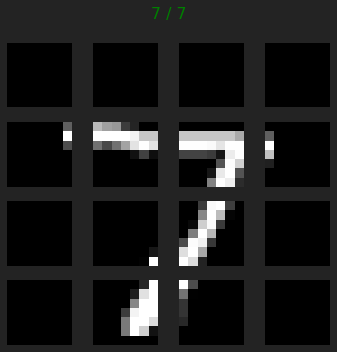

In [16]:
attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = 0
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()

## Resumen

En este post hemos implementado el mecanismo de atención básico utilizado en los *Transformers*, el *scaled dot-product attention*. Lo hemos aplicado a la clasificación de imágenes con MNIST, obteniendo buenos resultados pero nada impresionantes. Esto es debido a que este mecanismo, por sí solo, no provee de la suficiente potencia como para darnos una buena representación de nuestros datos. El mecanismo de atención implementado reutiliza pesos para cada *patch*, similar a una CNN. Sin embargo, solo hemos usado un conjunto de pesos, en una CNN equivaldría a un solo *kernel* o filtro. Para mejorar la capacidad de representación de una red convolucional, necesitamos usar muchos filtros. El equivalente a este concepto en los *Transofrmers* se conoce como *Multi-head attention*, de lo cual hablaremos en el siguiente post.